# Tutorial on RePaint

- First, modify the execution : Exécution > Modifier le type d'exécution > Accélérateur matériel > GPU

# Downloading the packages


In [1]:
! git clone https://github.com/andreas128/RePaint

Cloning into 'RePaint'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 85 (delta 43), reused 46 (delta 23), pack-reused 6
Unpacking objects: 100% (85/85), 52.06 KiB | 240.00 KiB/s, done.


In [2]:
!cd RePaint

In [10]:
!bash RePaint/download.sh

bash: RePaint/download.sh: No such file or directory


In [4]:
!pip install blobfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.1 MB/s eta 0:00:00


# Inside the code

In [5]:
import os
os.chdir('/content/RePaint')

In [6]:
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    select_args)
import sys
sys.argv=['']
del sys

from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display
from PIL import Image
import torch

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--conf_path', type=str, required=False, default=None)
args = vars(parser.parse_args())
args['conf_path'] = 'confs/face_example.yml'
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread(args.get('conf_path')))
args['conf_path'] = 'confs/face_example.yml'

In [9]:
conf = conf_arg

device = dist_util.dev(conf.get('device'))
print("device :")
print(device)

model, diffusion = create_model_and_diffusion(**select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)

model.eval()

device :
cuda


FileNotFoundError: ignored

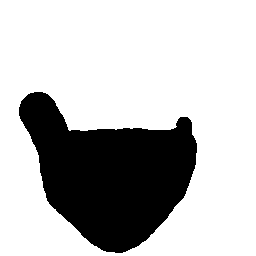

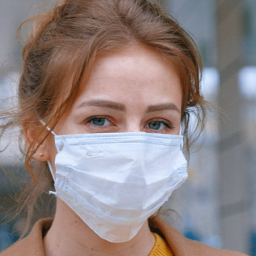

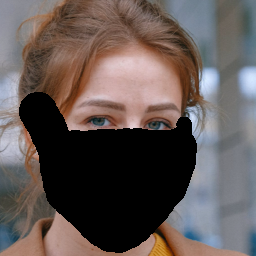

In [ ]:
os.chdir('/content/RePaint/data/datasets/gt_keep_masks/face')

mask = Image.open('000002.png')
display(mask)

os.chdir('/content/RePaint/data/datasets/gts/face')

img = Image.open('000002.png')
display(img)

img_masked = to_pil_image(to_tensor(img)*to_tensor(mask))
display(img_masked)

In [ ]:
conf.schedule_jump_params = {'t_T': 250, 'n_sample': 5, 'jump_length': 1, 'jump_n_sample': 1}
show_progress = conf.show_progress
batch = {}
img_GT = torch.unsqueeze(to_tensor(img),dim=0)
batch['GT'] = torch.stack([to_tensor(img)]*batch_size).to(device)

model_kwargs = {}

model_kwargs["gt"] = batch['GT']

model_kwargs['gt_keep_mask'] = to_tensor(mask).to(device)

def model_fn(x, t, y=None, gt=None, **kwargs):
        return model(x, t,None, gt=gt)

#Default : use_ddim is False.
sample_fn = diffusion.p_sample_loop

result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    device=device,
    progress=True,
    return_all=True,
    conf=conf)

ici


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

sample


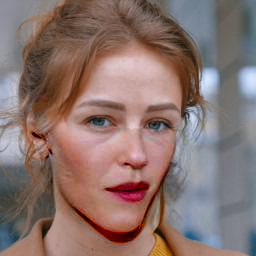

gt


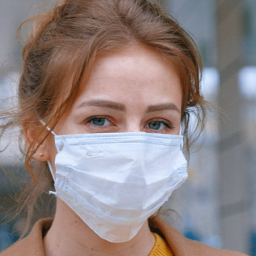

Masked


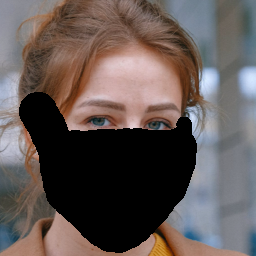

In [ ]:
print('sample')
for k in range (batch_size) :
    display(to_pil_image(result['sample'][k,:,:,:].cpu().clip(0,1)))
print('gt')
display(img)
print('Masked')
display(img_masked)

# Setting for generation

In [ ]:
nb_samples = 10

In [ ]:
conf.schedule_jump_params = {'t_T': 250, 'n_sample': 1, 'jump_length': 1, 'jump_n_sample': 1}
show_progress = conf.show_progress
batch = {}
batch_size = 1
img_GT = torch.unsqueeze(to_tensor(img),dim=0)
batch['GT'] = torch.stack([to_tensor(img)]*batch_size).to(device)

model_kwargs = {}

model_kwargs["gt"] = batch['GT']

model_kwargs['gt_keep_mask'] = 0.*to_tensor(mask).to(device)

def model_fn(x, t, y=None, gt=None, **kwargs):
        return model(x, t,None, gt=gt)

#Default : use_ddim is False.
sample_fn = diffusion.p_sample_loop

result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    device=device,
    progress=True,
    return_all=True,
    conf=conf)

In [ ]:
print('sample')
for k in range (batch_size) :
    display(to_pil_image(result['sample'][k,:,:,:].cpu().clip(0,1)))
print('gt')
display(img)
print('Masked')
display(img_masked)

# Further examples

I put my data at the url :

To generate mask on an image, you can use : https://ipolcore.ipol.im/demo/clientApp/demo.html?id=198

# For information: Code execution for an example

In [ ]:
!cd RePaint

In [ ]:
!python RePaint/test.py --conf_path RePaint/confs/face_example.yml

Start face_example
sampling...
  0% 2/4570 [01:40<62:29:04, 49.24s/it]